In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
#from sklearn.model_selection import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Loading train and test data

In [2]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
# To better understand the data types and values
train_data.info()
test_data.info()
# We have both numerical and categorical values

train_data.describe()
test_data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


# Dealing with missing values
We have 177 missing values in Age and 687 in Cabin. We can either drop all rows which have missing data or try and impute it. In this case I will impute Age with the median because "Age" is right skewed and using the mean might be biased.

Cabin feature I'll drop since the percentage of its missing values is too high and imputing won't be wise.

Embarked has only 2 NAs. Later we will see that the most common value for Embarked feature is S, so we can impute its missing values with S.

Fare I will also impute with the median

In [5]:
# Checking NAs in data
train_data.isnull().sum()
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

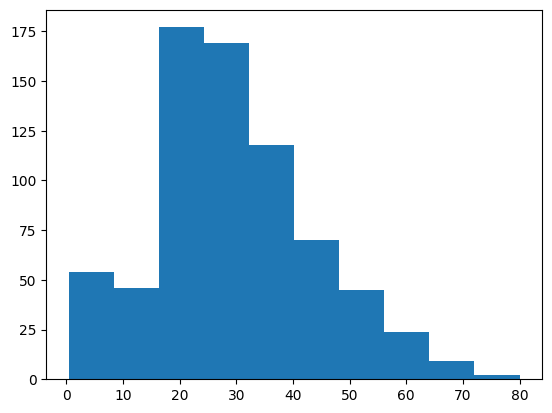

In [6]:
# Age bar plot
plt.hist(train_data["Age"])

# Filling in NAs in Age with the mode 
train_data = train_data.fillna({"Age" : train_data["Age"].mode()[0]})
test_data = test_data.fillna({"Age" : train_data["Age"].mode()[0]})

# Data exploration

In [7]:
# Splitting into numeric and categorial df for easier comparison
# We need to convert categorical values into numeric
df_num = train_data[ ['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = train_data[ ['Survived', 'Pclass', 'Sex','Embarked']]

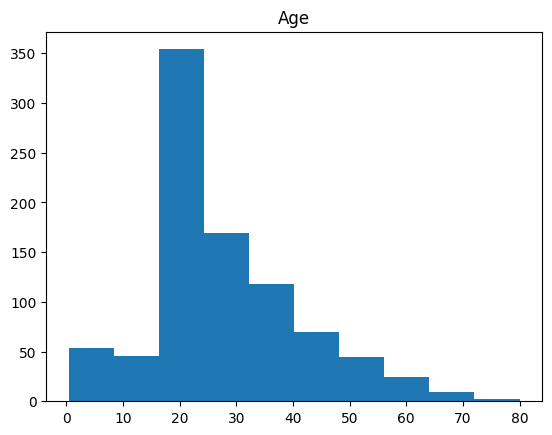

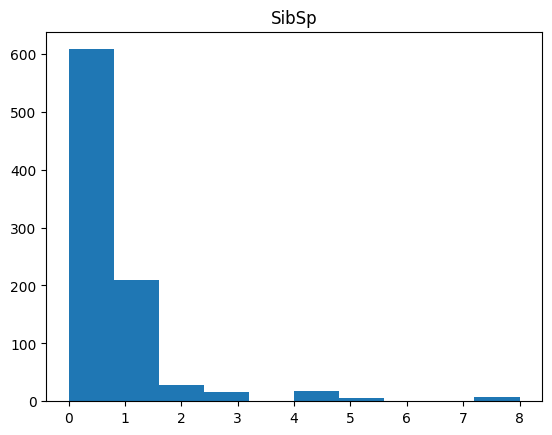

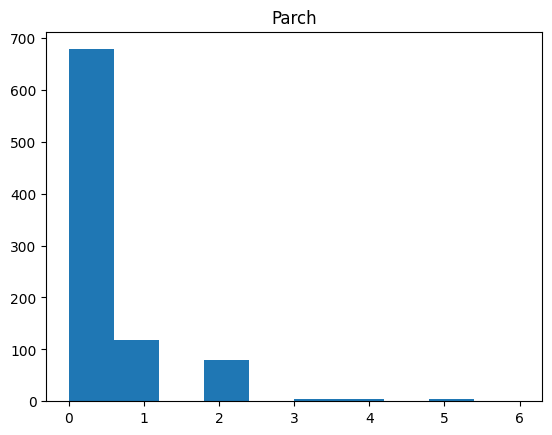

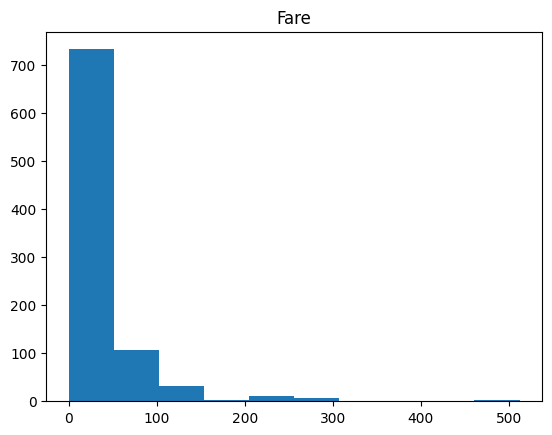

In [8]:
# Distributions for all numeric variables
# Need to normalize fare feature since it doesn`t follow normal distribution
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

            Age     SibSp     Parch      Fare
Age    1.000000 -0.232411 -0.155118  0.107554
SibSp -0.232411  1.000000  0.414838  0.159651
Parch -0.155118  0.414838  1.000000  0.216225
Fare   0.107554  0.159651  0.216225  1.000000


<Axes: >

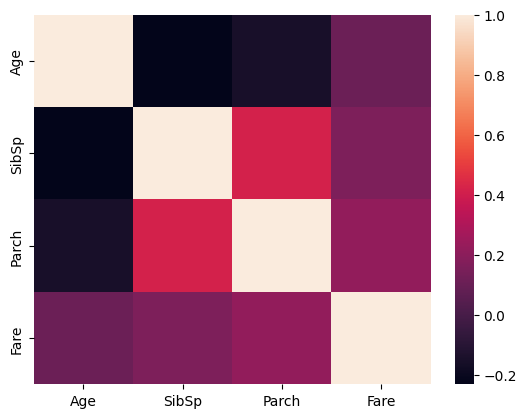

In [9]:
# Correlation is important to detect and avoid multicollinearity
print(df_num.corr())

# The number of parents and siblings have a correlation
sns.heatmap(df_num.corr())

In [10]:
# Compare the survival rate across Age, SibSp, Parch, and fare
pd.pivot_table(train_data, index = 'Survived', values = ['Age', 'SibSp', 'Parch'])

# Younger people have a higher chance of surving
# Rich have a higher chance of surviving

,Age,Parch,SibSp
Survived,,,
0,29.117486,0.329690,0.553734
1,27.683246,0.464912,0.473684


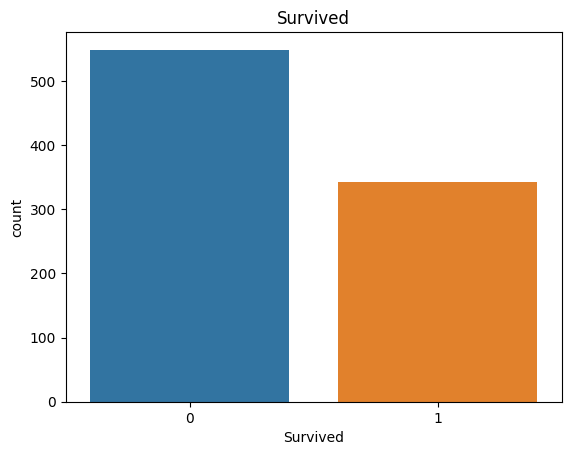

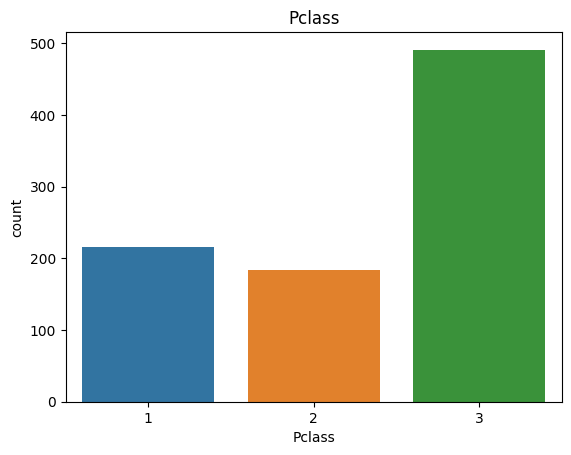

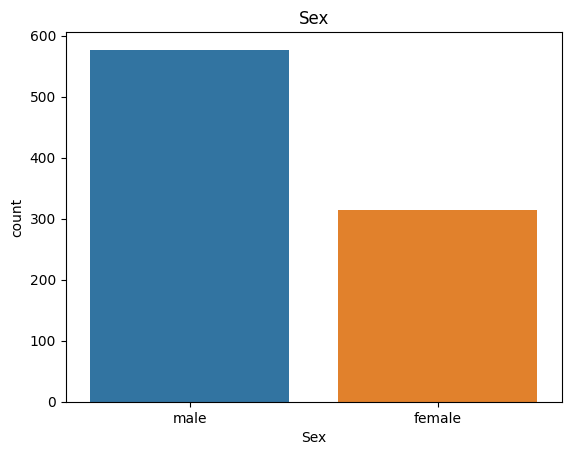

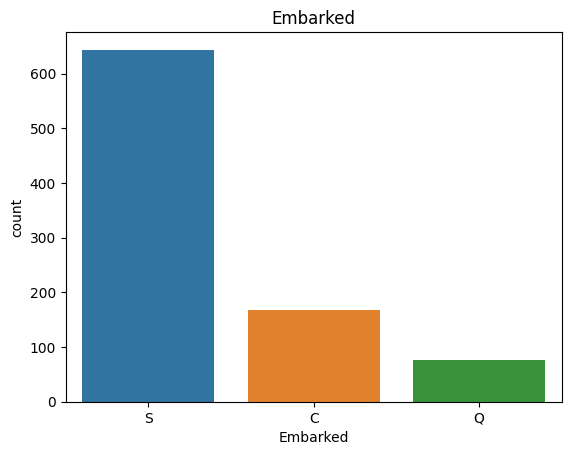

In [11]:
for i in df_cat.columns:
    sns.barplot(x= df_cat[i].value_counts().index, y = df_cat[i].value_counts())
    plt.title(i)
    plt.show()

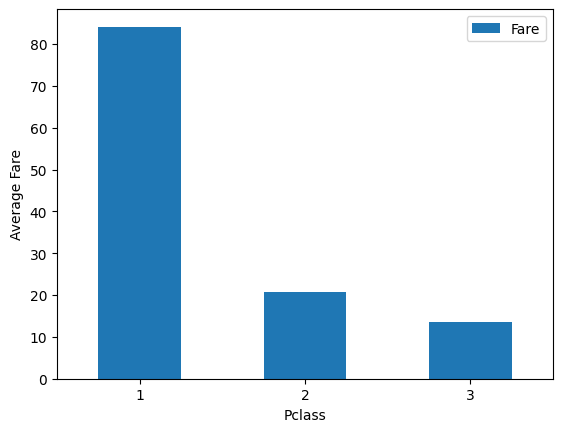

In [12]:
# Class vs Fare
pd.pivot_table(train_data, index = 'Pclass', values = 'Fare')
class_fare = train_data.pivot_table(index='Pclass', values='Fare')
class_fare.plot(kind='bar')
plt.xlabel('Pclass')
plt.ylabel('Average Fare')
plt.xticks(rotation=0)
plt.show()

# The higher fare - the better class

In [13]:
print(pd.pivot_table(train_data, index = 'Survived', columns = 'Pclass', values = 'Ticket', aggfunc = 'count'))
print()
print(pd.pivot_table(train_data, index = 'Survived', columns = 'Sex', values = 'Ticket', aggfunc = 'count'))
print()
print(pd.pivot_table(train_data, index = 'Survived', columns = 'Embarked', values = 'Ticket', aggfunc = 'count'))
print()



Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119

Sex       female  male
Survived              
0             81   468
1            233   109

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217



<Axes: xlabel='Survived', ylabel='Fare'>

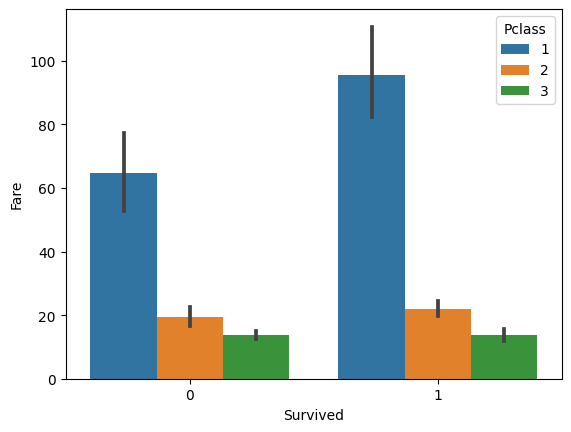

In [14]:
sns.barplot(train_data, x='Survived', y='Fare', hue='Pclass')

# Data preprocessing 

In [15]:
# The most common value for Embarked feature is S, so we can impute its missing value with S. 
train_data = train_data.fillna({'Embarked' : 'S'})
test_data = test_data.fillna({'Embarked' : 'S'})

# Filling in NAs in Fare with the median
train_data = train_data.fillna({"Fare" : train_data["Fare"].mode()[0]})
test_data = test_data.fillna({"Fare" : train_data["Fare"].mode()[0]})

In [16]:
# Log transformation for Fare
train_data['Fare'] = np.log(train_data['Fare']+1)
test_data['Fare'] = np.log(test_data['Fare']+1)

In [17]:
# Dropping unnecessary columns
train_data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)
test_data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)


In [18]:
# Label encoding for categorical features

le = preprocessing.LabelEncoder()
cols = ["Sex", "Embarked"]
for col in cols:
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
print(le.classes_)
train_data.info()
test_data.info()

['C' 'Q' 'S']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 55.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-nu

In [19]:
y = train_data ["Survived"] # Splitting response var
X = train_data.drop("Survived", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

predictions = model.predict(X_test)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[89, 16],
       [20, 54]])

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

AUC: 0.887129987129987


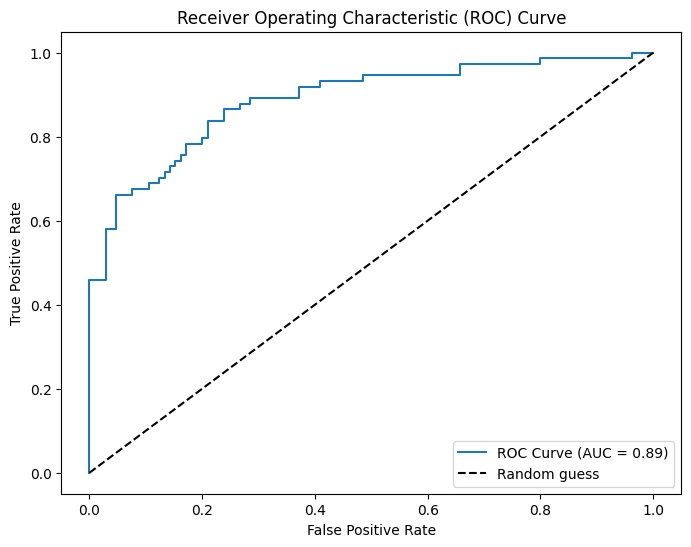

In [20]:
# F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. 
print(classification_report(y_test, predictions))

predictions_prob = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, predictions_prob)

# Calculate AUC 
roc_auc = roc_auc_score(y_test, predictions_prob)
print(f'AUC: {roc_auc}')

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

AUC value is 0.89, the model shows decent accuracy

In [21]:
# Getting model's accuracy at threshhold 0.6

from sklearn.metrics import accuracy_score

# Set the threshold
threshold = 0.6

# Convert predicted probabilities to binary predictions based on the threshold
predictions_binary = (predictions_prob > threshold).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions_binary)
print(f'Accuracy at threshold {threshold}: {accuracy:.2f}')

Accuracy at threshold 0.6: 0.81


# Test Submission

**Got the score of 0.77**

In [22]:
sub = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
sub['Survived'] = model.predict(test_data)
sub.head()
sub.to_csv('submission.csv', index=False)

# Things to improve:
* Change the set of variables in the model
* Impute age based on the median age of the class the NA is from
* Not include the number of siblings and parents in the model, just put the marker if they had any.
* Transform cabins to analyse their location and see if it affected model accuracy
* Names title mights also influence the accuracy
* Make a function to clean both train and test data
* Create other models and evaluate them